In [ ]:
# Enter this in console:

''' 

function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

'''

' \n\nfunction ConnectButton(){\n    console.log("Connect pushed"); \n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() \n}\nsetInterval(ConnectButton,60000);\n\n'

In [ ]:
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()
import pandas as pd
import datetime as dt
import math

from pyspark.sql import functions as F
import pyspark.sql.types as T
from pyspark.sql import Window
import matplotlib.pyplot as plt

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession\
  .builder\
  .config("spark.executor.memory", "8g")\
  .config("spark.driver.memory",'8g')\
  .getOrCreate()

In [ ]:
reviews = spark.read\
  .parquet("reviews.snappy.parquet")

movies = spark.read\
  .parquet("movies.snappy.parquet")

First we examine the different genres. We don't end up using any of this information for our predictive analytics, but it still enables us to look into how different genres perform.

In [ ]:
movies = movies.fillna("None", subset=["genres", 'audience_count', 'audience_rating'])
movies = movies.withColumn("genres_list", F.split(F.col("genres"), ', '))

movies_by_genre = movies.select(
    F.explode(F.col("genres_list")).alias('genre'),
    'audience_rating',
    'audience_count'
).groupby('genre').mean()

top_genres = [row['genre'] for row in 
              movies_by_genre.sort("avg(audience_count)", ascending=False).collect()[:10]]
print(top_genres)

['Science Fiction & Fantasy', 'Kids & Family', 'Animation', 'Romance', 'Action & Adventure', 'Comedy', 'Sports & Fitness', 'Mystery & Suspense', 'Drama', 'Horror']


In [ ]:
# Setting individual columns denoting whether the movie is of a certain genre
# Individual movies can be multiple genres
is_genre_udf = F.udf(lambda genre, genres_list: 1 if genre in genres_list else 0)

for genre in top_genres:
  movies = movies.withColumn(f"is_{genre}", is_genre_udf(F.lit(genre), F.col("genres_list")).cast("int"))

In [ ]:
# Combining the movie information with the review information

to_select_from_movies = ['rotten_tomatoes_link', 'original_release_date', 
                      'streaming_release_date', 'audience_count', 'audience_rating']

movie_reviews = reviews.select("rotten_tomatoes_link", 'review_type', 'review_date', 'top_critic', 'review_content')\
  .join(movies.select(*to_select_from_movies), on="rotten_tomatoes_link")

For each review, we identify the time period it was posted relative to the movie's theatrical run. Any reviews posted between 0 and 30 days after the movie's release is considered to have been posted in month 0.

In [ ]:
# Identifying the age of the movie in months at the time of each review

def set_month(date, release_date):
  month = math.floor((dt.datetime.strptime(date, '%Y-%m-%d')\
                      - dt.datetime.strptime(release_date, '%Y-%m-%d')).days/30)

  return month

set_months_udf = F.udf(lambda datetime, release_date: set_month(datetime, release_date))

movie_reviews = movie_reviews.where(F.col('review_date').isNotNull())
movie_reviews = movie_reviews.where(F.col('original_release_date').isNotNull())
movie_reviews = movie_reviews.where(F.col('streaming_release_date').isNotNull())

movie_reviews = movie_reviews\
  .withColumn("months_since_release", 
              set_months_udf(F.col('review_date'), F.col('original_release_date')).cast("int"))\
  .withColumn("months_since_streaming", 
              set_months_udf(F.col('review_date'), F.col('streaming_release_date')).cast("int"))

Next we set some numeric variables based on the binary classifications of whether the review was positive and whether the reviewer was a top critic. We then break down the classifications further to get more information about how the different groups of reviewers received the movie.

In [ ]:
# Setting numeric variables denoting whether the review was positive and whether the critic was a top critic

is_fresh_udf = F.udf(lambda x: 1 if x == 'Fresh' else 0)
top_critic_udf = F.udf(lambda x: 1 if x == True else 0)

movie_reviews = movie_reviews.withColumn("is_fresh", is_fresh_udf(F.col("review_type")))\
  .withColumn("is_top_critic", top_critic_udf(F.col("top_critic")))

In [ ]:
# Combining the two variables above into four separate categories
# This will be useful for aggregation later

movie_reviews = movie_reviews.withColumn("top_critic_fresh", F.col("is_fresh")*F.col("is_top_critic"))\
  .withColumn("top_critic_rotten", (1 - F.col("is_fresh"))*F.col("is_top_critic"))\
  .withColumn("non_top_critic_fresh", F.col("is_fresh")*(1 - F.col("is_top_critic")))\
  .withColumn("non_top_critic_rotten", (1 - F.col("is_fresh"))*(1 - F.col("is_top_critic")))

We identify each movie's age at the time the data was collected, based on the most recent review in the dataset. We don't use this later in our analysis, but it let's us filter out newer movies if we want aggregate movie performance over a long period of time (for example, if we wanted to look at the first two years of every movie's performance, we'd have to filter out movies that were released less than two years before the data was collected).

In [ ]:
# Identifying the age of the movie in months at time of data collection

max_date = reviews.agg(F.max(F.col('review_date'))).collect()[0]['max(review_date)']
movie_reviews = movie_reviews.withColumn("age_in_months", 
                                          set_months_udf(F.lit(max_date), F.col('original_release_date')).cast("int"))

We collect the reviews so we don't have to run the previous calculations every time we use the data.

In [ ]:
collected_reviews = spark.sparkContext.parallelize(movie_reviews.collect()).toDF()

Now we want to group the movies by movie and month. For each metric we want to observe, we look at the monthly data as well as the running total over the movie's run.

In [ ]:
cumulative_window = (Window.partitionBy("rotten_tomatoes_link")\
  .orderBy("months_since_release")\
  .rangeBetween(Window.unboundedPreceding, 0))

streaming_reviews = collected_reviews.where(F.col("streaming_release_date").isNotNull())

grouped_reviews = streaming_reviews.groupby("rotten_tomatoes_link", "months_since_release", 'audience_count', 'audience_rating', 'age_in_months')\
  .agg(F.min(F.col("months_since_streaming")).alias("months_since_streaming"),
       F.count(F.col("is_fresh")).alias("monthly_reviews"),
       F.sum(F.col("is_fresh")).alias("monthly_fresh_reviews"), 
       F.sum(1 - F.col("is_fresh")).alias("monthly_rotten_reviews"),
       F.sum(F.col("is_top_critic")).alias("monthly_top_critic_reviews"), 
       F.sum(1 - F.col("is_top_critic")).alias("monthly_non_top_critic_reviews"),
       F.sum(F.col("top_critic_fresh")).alias("monthly_top_fresh_reviews"), 
       F.sum(F.col("top_critic_rotten")).alias("monthly_top_rotten_reviews"),
       F.sum(F.col("non_top_critic_fresh")).alias("monthly_non_top_fresh_reviews"), 
       F.sum(F.col("non_top_critic_rotten")).alias("monthly_non_top_rotten_reviews"))

In [ ]:
grouped_reviews = grouped_reviews.withColumn("total_reviews", F.sum(F.col("monthly_reviews")).over(cumulative_window))\
  .withColumn("total_fresh_reviews", F.sum(F.col("monthly_fresh_reviews")).over(cumulative_window))\
  .withColumn("total_rotten_reviews", F.sum(F.col("monthly_rotten_reviews")).over(cumulative_window))\
  .withColumn("total_top_critic_reviews", F.sum(F.col("monthly_top_critic_reviews")).over(cumulative_window))\
  .withColumn("total_non_top_critic_reviews", F.sum(F.col("monthly_non_top_critic_reviews")).over(cumulative_window))\
  .withColumn("total_top_fresh_reviews", F.sum(F.col("monthly_top_fresh_reviews")).over(cumulative_window))\
  .withColumn("total_top_rotten_reviews", F.sum(F.col("monthly_top_rotten_reviews")).over(cumulative_window))\
  .withColumn("total_non_top_fresh_reviews", F.sum(F.col("monthly_non_top_fresh_reviews")).over(cumulative_window))\
  .withColumn("total_non_top_rotten_reviews", F.sum(F.col("monthly_non_top_rotten_reviews")).over(cumulative_window))

We collect the data again so we don't have to run these calculations each time.

In [ ]:
grouped_reviews = spark.sparkContext.parallelize(grouped_reviews.collect()).toDF()

Next, we group all the movies by month, so we can see how average performance changes over time. We want to look at the period after the movie is released and after it starts streaming.

In [ ]:
filtered_reviews = grouped_reviews.where(F.col("months_since_release") >= -1)\
  .where(F.col("months_since_release") <= 120)\
  .where(F.col("age_in_months") >= 12)

In [ ]:
col = "monthly_reviews"

avg_by_month_age = filtered_reviews.groupby('months_since_release')\
  .agg(F.mean(F.col(col)).alias("mean"), F.stddev(F.col(col)).alias("stddev")).sort("months_since_release")

month_data = avg_by_month_age.collect()

In [ ]:
months = [row['months_since_release'] for row in month_data]
avg_count = [row['mean'] for row in month_data]
upper = [row['mean'] + row['stddev'] for row in month_data]

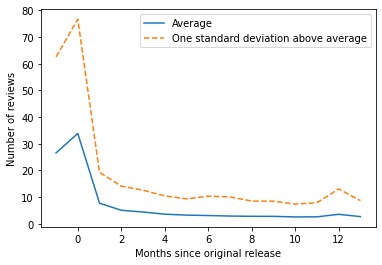

In [ ]:
i = 0
j = 15

plt.plot(months[i:j], avg_count[i:j])
plt.plot(months[i:j], upper[i:j], linestyle='dashed')
plt.xlabel('Months since original release')
plt.ylabel('Number of reviews')
plt.legend(['Average', 'One standard deviation above average'])
plt.show()

In [ ]:
stream_by_month = grouped_reviews.where(F.col("months_since_streaming") >= -10)\
  .where(F.col("months_since_streaming") <= 10).where(F.col('months_since_release') >= 3)

In [ ]:
col = "monthly_reviews"

stream_avg_by_month_age = stream_by_month\
  .groupby('months_since_streaming')\
  .agg(F.avg(F.col(col)).alias("mean"), F.stddev(F.col(col)).alias("stddev"))\
  .sort('months_since_streaming')

In [ ]:
month_data = stream_avg_by_month_age.where(F.col('stddev').isNotNull()).collect()

In [ ]:
months = [row['months_since_streaming'] for row in month_data]
avg_count = [row['mean'] for row in month_data]
upper = [row['mean'] + row['stddev'] for row in month_data]

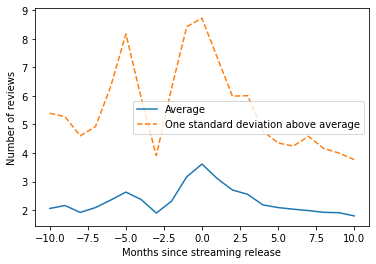

In [ ]:
i = 0
j = len(months)

plt.plot(months[i:j], avg_count[i:j])
plt.plot(months[i:j], upper[i:j], linestyle='dashed')
plt.xlabel('Months since streaming release')
plt.ylabel('Number of reviews')
plt.legend(['Average', 'One standard deviation above average'])
plt.show()

# Calculating drop-off rates and organizing all the data by film

We saw before that the monthly number of reviews drops drastically after the first month or so. What we call the "drop-off rate" is the rate of change between the monthly number of reviews from one month to the next. This data didn't have very much predictive power, and it requires us to wait two months to get information, but it does allow us to compare average movie performance just after release and just after streaming release.

In [ ]:
movie_window = (Window.partitionBy('rotten_tomatoes_link'))

dropoff_window = (Window.partitionBy('rotten_tomatoes_link')\
  .orderBy('months_since_release')\
  .rangeBetween(0, 1))

dropoffs = grouped_reviews\
  .drop('audience_count')\
  .drop('audience_rating')\
  .withColumn('absolute_change', (F.last('monthly_reviews').over(dropoff_window)-F.first('monthly_reviews').over(dropoff_window)))\
  .withColumn('percent_change', (F.last('monthly_reviews').over(dropoff_window)/F.first('monthly_reviews').over(dropoff_window))-1)\
  .withColumn('overall_reviews', F.max('total_reviews').over(movie_window))

pre_streaming = dropoffs.where(F.col("months_since_streaming") == -1)\
  .select('rotten_tomatoes_link',
          'monthly_fresh_reviews',
          'monthly_rotten_reviews',
          'total_fresh_reviews',
          'total_rotten_reviews',
          'absolute_change',
          (F.col('overall_reviews') - F.col('total_reviews')).alias("reviews_after_stream_release"))\
  .withColumnRenamed("monthly_fresh_reviews", "fresh_reviews_pre_stream_release")\
  .withColumnRenamed("monthly_rotten_reviews", "rotten_reviews_pre_stream_release")\
  .withColumnRenamed("total_fresh_reviews", "total_fresh_reviews_pre_stream_release")\
  .withColumnRenamed("total_rotten_reviews", "total_rotten_reviews_pre_stream_release")\
  .withColumnRenamed("absolute_change", "change_in_reviews_for_stream_release")

original_release = dropoffs.where((F.col('months_since_release') == 0))\
  .join(pre_streaming, on='rotten_tomatoes_link')\
  .sort('rotten_tomatoes_link', 'months_since_release')


grouped_movie_data_raw = original_release.join(movies, on="rotten_tomatoes_link")

In [ ]:
grouped_movie_data = spark.sparkContext.parallelize(grouped_movie_data_raw.collect()).toDF()

In [ ]:
first_year_of_release = dropoffs.where(F.col('months_since_release') >= -1)\
  .where(F.col('months_since_release') < 12)\
  .groupby('months_since_release')\
  .agg((F.sum(F.col('absolute_change'))/F.sum(F.col('monthly_reviews')) + 1).alias('average_rate_of_change'))\
  .sort('months_since_release')\
  .collect()

first_year_of_streaming = dropoffs.where(F.col('months_since_streaming') >= -1)\
  .where(F.col('months_since_streaming') < 12)\
  .groupby('months_since_streaming')\
  .agg((F.sum(F.col('absolute_change'))/F.sum(F.col('monthly_reviews')) + 1).alias('average_rate_of_change'))\
  .sort('months_since_streaming')\
  .collect()

We saw before that there were some similarities between the first few months after original release and the first few months after streaming release. This chart of the drop-off rates highlights those similarities: there's a significant drop after the first month, then a plateau.

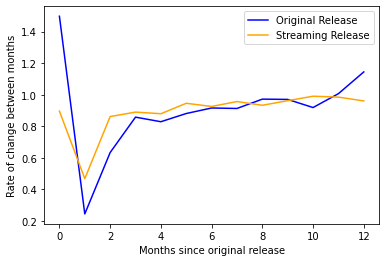

In [ ]:
release_x_values = [row['average_rate_of_change'] for row in first_year_of_release]
streaming_x_values = [row['average_rate_of_change'] for row in first_year_of_streaming]
months = [row['months_since_release'] + 1 for row in first_year_of_release]

plt.plot(months, release_x_values, color="blue")
plt.plot(months, streaming_x_values, color="orange")
plt.legend(["Original Release", 'Streaming Release'])
plt.ylabel('Rate of change between months')
plt.xlabel('Months since original release')

plt.show()

There seems to be some conflict with this result and the previous graphs. This graph indicates that movies tend to get less reviews when they start streaming. If we see how many movies had an increase in monthly reviews when they started streaming, we see that very few of them did, and these were just pulling the average numbers up.

In [ ]:
was_success_udf = F.udf(lambda x: 1 if x > 0 else 0)

dropoffs.where(F.col('months_since_streaming') == 0)\
  .select(was_success_udf(F.col('absolute_change')).alias('stream_success'))\
  .groupby('stream_success')\
  .count().show()

+--------------+-----+
|stream_success|count|
+--------------+-----+
|             0| 2249|
|             1|  262|
+--------------+-----+



We also want to know what the average percent change in reviews is over time, discounting the first month and the month just before a movie starts streaming. On average, the decay rate seems to be about 7.77% from month to month.

In [ ]:
dropoffs.where(F.col('months_since_release') > 0)\
  .where(F.col("months_since_streaming") != -1)\
  .groupby('months_since_release')\
  .agg(F.sum("absolute_change"), F.sum("monthly_reviews"))\
  .select(F.sum(F.col("sum(absolute_change)"))/F.sum(F.col("sum(monthly_reviews)")))\
  .show()

+-------------------------------------------------------+
|(sum(sum(absolute_change)) / sum(sum(monthly_reviews)))|
+-------------------------------------------------------+
|                                   -0.07773661211707147|
+-------------------------------------------------------+



# Linear Regression - how to predict long-term success or streaming success

In [ ]:
# Proportion of all reviews that arrive in the first month 
grouped_movie_data.select(F.sum(F.col("monthly_reviews"))/F.sum(F.col("overall_reviews"))).show()

+---------------------------------------------+
|(sum(monthly_reviews) / sum(overall_reviews))|
+---------------------------------------------+
|                           0.3701266509021781|
+---------------------------------------------+



In [ ]:
# Proportion of all reviews that arrive by end of first month 
grouped_movie_data.select(F.sum(F.col("total_reviews"))/F.sum(F.col("overall_reviews"))).show()

+-------------------------------------------+
|(sum(total_reviews) / sum(overall_reviews))|
+-------------------------------------------+
|                         0.7246493114627804|
+-------------------------------------------+



In [ ]:
def linear_regression(input_cols, y_variable, data_frame):

  assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

  output = assembler.transform(data_frame)
  finalData = output.select('features', y_variable)
  trainData, testData = finalData.randomSplit([0.7, 0.3], seed=100)
  lrModel = LinearRegression(labelCol = y_variable, featuresCol = 'features')
  lrEstimator = lrModel.fit(trainData)

  trainResults = lrEstimator.evaluate(trainData)
  testResults = lrEstimator.evaluate(testData)

  print(f"Train r-squared: {trainResults.r2}")
  print(f"Test r-squared: {testResults.r2}")
  print(f"Train MSE: {trainResults.meanSquaredError}")
  print(f"Test MSE: {testResults.meanSquaredError}")

  return lrEstimator

We know many of the reviews come in the first month after release. We want to how much we can predict from this early information. 

Our first model predicts the total number of reviews from information gathered in the first month. We use the total number of reviews as a metric for a movie's popularity. We only take information from the first month, and not before, and only consider whether the review was positive or negative, as we want a model that would work for Netflix (which does not allow for text reviews nor for posting reviews before a property is released). After some experimenting, we found that the raw monthly numbers of fresh and rotten reviews for the first month had the best performance on the test dataset.

In [ ]:
# Regressing overall number of reviews on total reviews by end of first month

input_cols1 = [
              'monthly_fresh_reviews',
              'monthly_rotten_reviews'
              ]
y_variable1 = 'overall_reviews'

lrEstimator1 = linear_regression(input_cols1, y_variable1, grouped_movie_data)

Train r-squared: 0.8432393300408065
Test r-squared: 0.8542449846756699
Train MSE: 2666.88395410728
Test MSE: 2255.989372653295


In [ ]:
for i in range(len(input_cols1)):
  col = input_cols1[i]
  coeff = round(lrEstimator1.coefficients[i], 5)
  print(f"{col} coefficient = {coeff}")

monthly_fresh_reviews coefficient = 2.62298
monthly_rotten_reviews coefficient = 1.66755


Our second model looks at the total number of reviews a movie gets after it starts streaming. For this model we considered a couple more variables, including the movie's age in months by the time it starts streaming and its performance just before the streaming release. The idea for this model was to use it to predict how well an acquired property would perform if it were to start streaming next month.

While this model can provide more specific/more actionable information than the first model, it wasn't as reliable on test data.

In [ ]:
# Regressing post-streaming success

input_cols2 = [
              'months_since_streaming',
              'total_fresh_reviews',
              'total_rotten_reviews',
              'total_fresh_reviews_pre_stream_release',
              'total_rotten_reviews_pre_stream_release'
              ]
y_variable2 = 'reviews_after_stream_release'

lrEstimator2 = linear_regression(input_cols2, y_variable2, grouped_movie_data)

Train r-squared: 0.779564476277621
Test r-squared: 0.6481404196329615
Train MSE: 421.387994931254
Test MSE: 501.1881459366627


In [ ]:
for i in range(len(input_cols2)):
  col = input_cols2[i]
  coeff = round(lrEstimator2.coefficients[i], 5)
  print(f"{col} coefficient = {coeff}")

months_since_streaming coefficient = 0.05167
total_fresh_reviews coefficient = 0.30177
total_rotten_reviews coefficient = 0.12186
fresh_reviews_pre_stream_release coefficient = 0.40969
rotten_reviews_pre_stream_release coefficient = 0.59395


The third model tries to predict how many more reviews a movie will get during the month it starts streaming compared to the month before. This model uses the same variables as the previous model, but, as it is attempting to predict pver a much smaller window of time, had much worse performance over the test dataset.

In [ ]:
# Regressing streaming launch success

input_cols3 = [
              'months_since_streaming',
              'total_fresh_reviews',
              'total_rotten_reviews',
              'fresh_reviews_pre_stream_release',
              'rotten_reviews_pre_stream_release'
              ]
y_variable3 = 'change_in_reviews_for_stream_release'
lrEstimator3 = linear_regression(input_cols3, y_variable3, grouped_movie_data)

Train r-squared: 0.3249271156837761
Test r-squared: 0.2809785151012423
Train MSE: 430.25679651598284
Test MSE: 373.51298430946053


In [ ]:
for i in range(len(input_cols3)):
  col = input_cols3[i]
  coeff = round(lrEstimator3.coefficients[i], 5)
  print(f"{col} coefficient = {coeff}")

months_since_streaming coefficient = 0.02571
total_fresh_reviews coefficient = 0.03657
total_rotten_reviews coefficient = 0.02601
fresh_reviews_pre_stream_release coefficient = -0.58033
rotten_reviews_pre_stream_release coefficient = -0.23893


# Random Forest Regression

Next, we use random forest models to see if we can improve our performance over the linear regression models. Each of the next three models corresponds to one of the linear regression models, sharing the same input and output variables.

In [ ]:
def rf_model(input_cols, y_variable, data_frame):

  assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

  output = assembler.transform(data_frame)
  finalData = output.select('features', y_variable)
  trainData, testData = finalData.randomSplit([0.7, 0.3], seed=100)

  rfModel = RandomForestRegressor(featuresCol="features", labelCol=y_variable)
  rfEstimator = rfModel.fit(trainData)

  rfTrainPredictions = rfEstimator.transform(trainData)
  rfTestPredictions = rfEstimator.transform(testData)
  r2_evaluator = RegressionEvaluator(labelCol=y_variable, metricName="r2")
  mse_evaluator = RegressionEvaluator(labelCol=y_variable, metricName="mse")

  trainResults_r2 = r2_evaluator.evaluate(rfTrainPredictions)
  testResults_r2 = r2_evaluator.evaluate(rfTestPredictions)
  trainResults_mse = mse_evaluator.evaluate(rfTrainPredictions)
  testResults_mse = mse_evaluator.evaluate(rfTestPredictions)

  print(f"Train r-squared: {trainResults_r2}")
  print(f"Test r-squared: {testResults_r2}")
  print(f"Train MSE: {trainResults_mse}")
  print(f"Test MSE: {testResults_mse}")

  return rfTestPredictions

In [ ]:
rfTestPredictions1 = rf_model(input_cols1, y_variable1, grouped_movie_data)

Train r-squared: 0.8428343620408955
Test r-squared: 0.8412586716687693
Train MSE: 2673.7734542680732
Test MSE: 2456.9909235661466


Train r-squared: 0.8547348884112989
Test r-squared: 0.8629253109176391
Train MSE: 0.21987093273028033
Test MSE: 0.21600911218403215


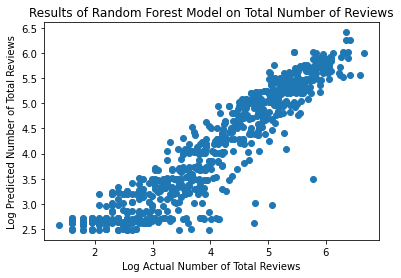

In [ ]:
# Regressing overall number of reviews on total reviews by end of first month

# rfTestPredictions1 = rf_model(input_cols1, y_variable1, grouped_movie_data)
rfTestPredictions1 = rf_model(input_cols1, 'log_reviews', grouped_movie_data.withColumn('log_reviews', F.log('overall_reviews')))

rfTestPredictions1 = rfTestPredictions1.collect()

# true_values = [row['overall_reviews'] for row in rfTestPredictions1]
true_values = [row['log_reviews'] for row in rfTestPredictions1]
predicted_values = [row['prediction'] for row in rfTestPredictions1]

plt.scatter(true_values, predicted_values)
plt.ylabel('Log Predicted Number of Total Reviews')
plt.xlabel('Log Actual Number of Total Reviews')
plt.title('Results of Random Forest Model on Total Number of Reviews')
plt.show()

In [ ]:
# Regressing post-streaming success

rfTestPredictions2 = rf_model(input_cols2, y_variable2, grouped_movie_data)

Train r-squared: 0.7473659656947811
Test r-squared: 0.6827910080789361
Train MSE: 485.8943291389046
Test MSE: 442.99267814652796


In [ ]:
# Regressing streaming launch success

rfTestPredictions3 = rf_model(input_cols3, y_variable3, grouped_movie_data)

Train r-squared: 0.5820952083719351
Test r-squared: 0.3739727705782583
Train MSE: 266.3510578960596
Test MSE: 325.2048841812043


# Sentiment analysis to learn more

We then use sentiment analysis to try to gain a bit more data about the reviews. This model would only apply to online reviews for acquired properties, as Netflix does not allow for text reviews, so they cannot run sentiment analysis on their user's responses. 

Earlier, we found that the raw numbers of positive and negative reviews were good predictors of overall performance. Using the same logic, we too each movie's combined positive and negative sentiments from reviews posted up to a month after the original release, then use these values as independent variables in our regression.

In [ ]:
reviews_for_sent = collected_reviews.where(F.col('months_since_release') <= 0)\
  .select('review_content', 'rotten_tomatoes_link', F.col('is_fresh').cast('int'), 'months_since_release')\
  .fillna('', subset='review_content')

In [ ]:
sentiment = F.udf(lambda x: TextBlob(x).sentiment[0])
reviews_for_sent = reviews_for_sent.withColumn('sentiment_score', sentiment(F.col('review_content')).cast('double'))
reviews_for_sent = spark.sparkContext.parallelize(reviews_for_sent.collect()).toDF()

In [ ]:
positive_sentiment_udf = F.udf(lambda x: x if x > 0 else 0)
negative_sentiment_udf = F.udf(lambda x: x if x < 0 else 0)

reviews_for_sent = reviews_for_sent.withColumn('positive_sentiment', positive_sentiment_udf(F.col('sentiment_score')))\
  .withColumn('negative_sentiment', negative_sentiment_udf(F.col('sentiment_score')))

In [ ]:
  # .where(F.col('months_since_release') == 0)\
grouped_sentiment = reviews_for_sent\
  .groupby('rotten_tomatoes_link')\
  .agg(F.mean(F.col('sentiment_score')).alias('average_sentiment'),
       F.sum(F.col('sentiment_score')).alias('net_sentiment'),
       F.sum(F.col('positive_sentiment')).alias('total_positive_sentiment'),
       F.sum(F.col('negative_sentiment')).alias('total_negative_sentiment'))
  
grouped_sentiment = spark.sparkContext.parallelize(
    grouped_sentiment.join(grouped_movie_data, on='rotten_tomatoes_link').collect()).toDF()

In [ ]:
# Using sentiment scores to improve our models from before
# Sentiment scores are for reviews up until the end of the first month after the movie's initial release

input_colsS = [
              # 'months_since_streaming',
              # 'total_non_top_fresh_reviews',
              # 'total_non_top_rotten_reviews',
              'monthly_non_top_fresh_reviews',
              'monthly_non_top_rotten_reviews',
              # 'total_fresh_reviews_pre_stream_release',
              # 'total_rotten_reviews_pre_stream_release',
              'average_sentiment',
              'total_positive_sentiment',
              'total_negative_sentiment'
]
y_variableS = 'overall_reviews'
# y_variableS = 'reviews_after_stream_release'
# y_variableS = 'change_in_reviews_for_stream_release'

linear_regression(input_colsS, y_variableS, grouped_sentiment)

Train r-squared: 0.9424316010922148
Test r-squared: 0.9368273761939988
Train MSE: 966.4806706142571
Test MSE: 1010.1674294402924


LinearRegressionModel: uid=LinearRegression_62c35c74c724, numFeatures=5

Train r-squared: 0.924715440550418
Test r-squared: 0.9127420176970358
Train MSE: 0.11436087842069731
Test MSE: 0.13638698631225074


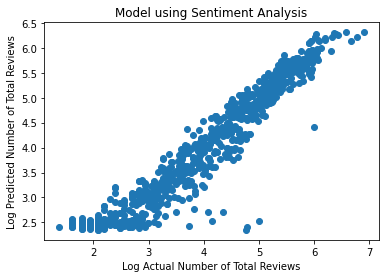

In [ ]:
rfTestPredictionsS = rf_model(input_colsS, 'log_reviews', grouped_sentiment.withColumn('log_reviews', F.log('overall_reviews')))
# rfTestPredictionsS = rf_model(input_colsS, y_variableS, grouped_sentiment)
rfTestPredictionsS = rfTestPredictionsS.collect()

true_values = [row['log_reviews'] for row in rfTestPredictionsS]
predicted_values = [row['prediction'] for row in rfTestPredictionsS]

plt.scatter(true_values, predicted_values)
plt.ylabel('Log Predicted Number of Total Reviews')
plt.xlabel('Log Actual Number of Total Reviews')
plt.title('Model using Sentiment Analysis')
plt.show()

# Examining the period after streaming release


Lastly, we tried focusing on the period after a movie starts streaming, as we earlier saw that the flow of reviews seems to change after a movie starts streaming, mirroring how it looked after the original release.

We tried predicting the total number of reviews after the streaming release and the total number of reviews during the month of the streaming release, using positive/negative review counts and sentiment scores of reviews from the first month after a movie starts streaming.

In [ ]:
stream_release = dropoffs.where(F.col("months_since_streaming") == 0)\
  .withColumn('reviews_after_stream_release',
          (F.col('overall_reviews') - F.col('total_reviews') + F.col('monthly_reviews')))\
  .withColumn("reviews_after_first_month_streaming", 
          (F.col('overall_reviews') - F.col('total_reviews')))

grouped_streaming_data_raw = stream_release.join(movies, on="rotten_tomatoes_link")

In [ ]:
stream_reviews_for_sent = collected_reviews.where(F.col('months_since_streaming') == 0)\
  .select('review_content', 'rotten_tomatoes_link', F.col('is_fresh').cast('int'), 'months_since_streaming')\
  .fillna('', subset='review_content')

In [ ]:
stream_reviews_for_sent = stream_reviews_for_sent.withColumn('sentiment_score', sentiment(F.col('review_content')).cast('double'))
stream_reviews_for_sent = spark.sparkContext.parallelize(stream_reviews_for_sent.collect()).toDF()

In [ ]:
stream_reviews_for_sent = stream_reviews_for_sent.withColumn('positive_sentiment', positive_sentiment_udf(F.col('sentiment_score')))\
  .withColumn('negative_sentiment', negative_sentiment_udf(F.col('sentiment_score')))

grouped_stream_sentiment = stream_reviews_for_sent.groupby('rotten_tomatoes_link')\
  .agg(F.mean(F.col('sentiment_score')).alias('average_sentiment'),
       F.sum(F.col('sentiment_score')).alias('net_sentiment'),
       F.sum(F.col('positive_sentiment')).alias('total_positive_sentiment'),
       F.sum(F.col('negative_sentiment')).alias('total_negative_sentiment'))
  
grouped_stream_sentiment = spark.sparkContext.parallelize(
    grouped_stream_sentiment.join(grouped_streaming_data_raw, on='rotten_tomatoes_link').collect()).toDF()

In [ ]:
# Using sentiment scores to improve our models from before
# Sentiment scores are for reviews up until the end of the first month after the movie's initial release

input_colsSt = [
  'monthly_fresh_reviews',
  'monthly_rotten_reviews',
  'total_positive_sentiment',
  'average_sentiment'
]

y_variableSt = 'reviews_after_stream_release'
# y_variableSt = 'reviews_after_first_month_streaming'
linear_regression(input_colsSt, y_variableSt, grouped_stream_sentiment)

Train r-squared: 0.5894517040802774
Test r-squared: 0.5924458736317579
Train MSE: 558.7070334957886
Test MSE: 491.2459524544911


LinearRegressionModel: uid=LinearRegression_3977f5f5073a, numFeatures=4

In [ ]:
rf_model(input_colsSt, y_variableSt, grouped_stream_sentiment)

Train r-squared: 0.6128493486336288
Test r-squared: 0.5371134603422185
Train MSE: 526.8656430695862
Test MSE: 557.9409564046301


DataFrame[features: vector, reviews_after_stream_release: bigint, prediction: double]